# Note
## Jun. 6
>Status
1. By now, the best regressor is simple LassoCV using CV = 5
2. For categorical feature, use OneHot encoder.
3. The features having unique values, are dropped.
4. Try box-cox change of Y, but no imporvement.

>TODO
1. More work on feature engineering, try to reduce the dimension:
 + PCA
 + delete the dimensions with small variance

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
train_df = pd.read_csv('train.csv')
train_y = train_df.y
train_x = train_df.drop(['ID','y'],axis = 1)
test_df = pd.read_csv('test.csv')
test_x =  test_df.drop(['ID'],axis = 1)
cat_cols = train_x.select_dtypes(['object']).columns

# Compare training set and test set

# Feature engineering
## Issue: Categorical value of train and test are different
+ Sol-1:  try to change the catogorical data in test set to values existant in training set. 
+ Sol-2: Use the mean of data

In [5]:
#for col in cat_cols:
#    print col, set(test_df[col].unique()).difference(set(train_x[col].unique()))

In [6]:
#x0_tran = {'ae':'ad', 'ag':'af','bb':'ba','an':'am','p':'r','av':'aw'}
#x2_tran = {'ab':'ac', 'ad':'ae', 'aj':'ai', 'u':'t', 'w':'x', 'ax':'ay'}
#x5_tran = {'a':'aa', 'b':'c', 't':'r', 'z':'y'}

#test_x['X0'] = map(lambda x: x0_tran[x] if x in x0_tran.keys() else x, test_x['X0'])
#test_x['X2'] = map(lambda x: x2_tran[x] if x in x2_tran.keys() else x, test_x['X2'])
#test_x['X5'] = map(lambda x: x5_tran[x] if x in x5_tran.keys() else x, test_x['X5'])

In [ ]:
def fill_missingOFtest(df):
    df
    

## Encode the categorical data

In [47]:
from sklearn.preprocessing import LabelBinarizer
# fit the Label binarizer
lbs = list()
for col in cat_cols:
    lb = LabelBinarizer().fit(train_x[col])
    lbs.append(lb)

# transform the trianing set
for col, lb in zip(cat_cols,lbs):
    bina_df = pd.DataFrame(lb.transform(train_x[col]),
                           columns= map(lambda x: col + '_' + str(x), range(len(lb.classes_))))
    train_x = pd.concat([train_x, bina_df], axis=1)

# transform the test set    
for col,lb in zip(cat_cols, lbs):
    bina_df = pd.DataFrame(lb.transform(test_x[col]),
                           columns= map(lambda x: col + '_' + str(x), range(len(lb.classes_))))
    bina_df.loc[bina_df.sum(axis = 1) == 0] =1./len(lb.classes_)
    test_x = pd.concat([test_x, bina_df], axis=1)
# drop the categorical data
train_x.drop(cat_cols, axis =1, inplace=True)
test_x.drop(cat_cols, axis =1, inplace=True)

In [48]:
print train_x.shape, test_x.shape

(4209, 563) (4209, 563)


# drop features which are collineare.

In [49]:
# if all the values are the same, then drop all
for col in [col  for col in train_x.columns if len(np.unique(train_x[col]))==1 ]:
    train_x.drop(col, axis = 1, inplace= True)
    test_x.drop(col, axis =1, inplace=True)

In [50]:
# if several columns are equal, then drop all and create new one
train_corr = train_x.corr()
colli = list()
for col in range(train_corr.shape[0]):
    for index in range(col):
        if train_corr.iloc[index, col] == 1:
            colli.append([index, col])
def get_group(collis):
    groups = list()
    for coll in colli:
        ctr = True
        for i in range(len(groups)):
            if coll[0] in groups[i] or coll[1] in groups[i]:
                groups[i] = groups[i]|{coll[0], coll[1]}
                ctr = False
        if ctr:
            groups.append({coll[0], coll[1]})
    return groups
groups = get_group(colli)
for group in groups:
    col = 'C_'+ str(group)
    train_x[col] = train_x.iloc[:,list(group)].mean(axis=1)
    test_x[col] = test_x.iloc[:,list(group)].mean(axis=1)
cols_drop = list()
for group in groups:
    cols_drop.append(train_x.columns[list(group)])
for col in cols_drop:
    train_x.drop(col, axis = 1, inplace=True)
    test_x.drop(col, axis = 1, inplace=True)
print train_x.shape, test_x.shape

(4209, 478) (4209, 478)


## Use PCA

In [25]:
from sklearn.decomposition import PCA
if False:
    pca = PCA(n_components=136)
    pca.fit(train_x)
    train_x = pca.transform(train_x)
    test_x = pca.transform(test_x)

pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
for i in range(200):
    if pca_cumsum[i] > 0.95:
        print i
        break

# Regression
## RandomForest

In [51]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=4, max_features = 0.618, n_jobs= -1)

In [55]:
from sklearn.model_selection import GridSearchCV
rf_regcv = GridSearchCV(rf_reg,
                        {'n_estimators':[100,300,500]})
rf_regcv.fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=0.618, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
rf_regcv.grid_scores_

E:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55926, std: 0.03813, params: {}]

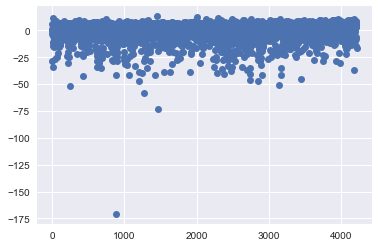

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   6.00000000e+00,   2.80000000e+01,
          5.60000000e+01,   1.41000000e+02,   4.04000000e+02,
          2.26400000e+03,   1.30600000e+03]),
 array([-170.81076951, -161.61168386, -152.41259822, -143.21351257,
        -134.01442693, -124.81534128, -115.61625564, -106.41716999,
         -97.21808435,  -88.0189987 ,  -78.81991306,  -69.62082741,
         -60.42174177,  -51.22265612,  -42.02357048,  -32.82448483,
         -23.62539919,  -14.42631354,   -5.2272279 ,    3.97185775,
          13.17094339]),
 <a list of 20 Patch objects>)

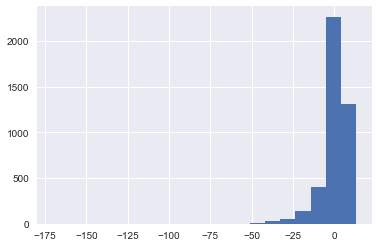

In [66]:
residual = rf_reg.predict(train_x) - train_y
plt.plot(residual, 'o')
plt.show()
plt.hist(residual, bins = 20)

In [70]:
test_pred = rf_reg.predict(test_x)
pd.DataFrame({'ID':test_df.ID,'y':test_pred}).to_csv('res_rf.csv',index =False)

In [71]:
train_df.plot?